In [4]:
import os
# Check if running in a notebook or script to avoid errors on os.chdir
try:
    if os.path.exists(r"C:\Users\KAUSHIK\CreditPathAI_Oct_Batch"):
        os.chdir(r"C:\Users\KAUSHIK\CreditPathAI_Oct_Batch")
except:
    pass # Assume environment is already set

import pandas as pd
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import (
    accuracy_score, recall_score, f1_score, confusion_matrix,
    roc_auc_score
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE

# FIX 1: Correct the file path
df = pd.read_csv("Loan_Default.csv") 

# --- Data Cleaning and Encoding Setup ---
TARGET = "Status"
ID_COL = "ID" # Assuming ID exists, remove it later

# Impute NaNs with median/mode (as per your original code)
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

if TARGET in cat_cols: cat_cols.remove(TARGET)
if TARGET in num_cols: num_cols.remove(TARGET)
if ID_COL in num_cols: num_cols.remove(ID_COL)
if ID_COL in cat_cols: cat_cols.remove(ID_COL)


for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# Label Encode the Target
le = LabelEncoder()
df[TARGET] = le.fit_transform(df[TARGET])

# --- Preprocessing Pipeline Definition (The FIX for feature mismatch) ---
# We define the ColumnTransformer BEFORE splitting/fitting to ensure it's saved correctly
preprocessor = ColumnTransformer(
    transformers=[
        # Scaling numerical features
        ("num", StandardScaler(), num_cols),
        # One-Hot Encoding categorical features
        # handle_unknown='ignore' ensures constant feature count
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
    ],
    remainder='passthrough'
)

# ----------------- Model Training -----------------
X = df.drop(columns=[TARGET])
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Fit and Transform data using the Preprocessor
# X_train_processed is now a NumPy array of features
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# SMOTE only on processed training data
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train_processed, y_train)

models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, class_weight='balanced'),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(kernel='linear', max_iter=1000, probability=True, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=200, class_weight='balanced'),
    "XGBoost": xgb.XGBClassifier(eval_metric='logloss', random_state=42, use_label_encoder=False),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

results = []
trained_models = {}

for name, model in models.items():
    print(f"Training Model: {name}")
    start_train = time.time()
    # Train using the processed data
    model.fit(X_train_sm, y_train_sm)
    end_train = time.time()
    train_time = end_train - start_train

    trained_models[name] = model

    # Training Metrics
    y_train_pred = model.predict(X_train_sm)
    # ... (Rest of your training metric calculation code)

    # TEST PREDICTION - Use the processed test data
    y_pred = model.predict(X_test_processed)
    # ... (Rest of your test metric calculation code)
    
    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    test_specificity = tn / (tn + fp)
    
    # Store results (simplified for brevity)
    results.append([name, acc * 100, rec * 100, f1 * 100, train_time, 0])


results_df = pd.DataFrame(results, columns=["Model", "Test Accuracy", "Test Sensitivity", "Test F1", "Training Time (sec)", "Prediction Time (sec)"])
print("\n===== FINAL RESULTS =====\n")
print(results_df)

# =========================================================================
# 🎯 FINAL FIX SECTION: SAVE PREPROCESSOR AND BEST MODEL (Step 2 & 3)
# =========================================================================

# 1. Save the fitted preprocessor
try:
    with open('preprocessor.pkl', 'wb') as file:
        pickle.dump(preprocessor, file)
    print("Successfully saved preprocessor.pkl")
except Exception as e:
    print(f"Error during preprocessor saving: {e}")

# 2. Identify and save the best model
if not results_df.empty:
    best_model_row = results_df.loc[results_df['Test F1'].idxmax()]
    best_model_name = best_model_row['Model']
    best_model_object = trained_models[best_model_name]

    print(f"\nSaving the Best Model: {best_model_name} (Test F1 Score: {best_model_row['Test F1']:.2f}%)")

    try:
        # Save the actual model object, fixing the 'numpy.ndarray' error
        with open('best_model.pkl', 'wb') as file:
            pickle.dump(best_model_object, file)
        print("Successfully saved best_model.pkl")

        # Save results (for display in app)
        results_df.to_csv("final_model_metrics.csv", index=False)
        
    except Exception as e:
        print(f"Error during model saving: {e}")

# Ensure you run the visualisations if needed
# ... (Your plot code here)

Training Model: Logistic Regression
Training Model: Naive Bayes
Training Model: SVM
Training Model: Decision Tree
Training Model: Random Forest
Training Model: XGBoost
Training Model: KNN

===== FINAL RESULTS =====

                 Model  Test Accuracy  Test Sensitivity     Test F1  \
0  Logistic Regression      85.289567         65.957060   68.847633   
1          Naive Bayes      30.911863         99.344978   41.478330   
2                  SVM      46.162642         57.523654   34.497245   
3        Decision Tree     100.000000        100.000000  100.000000   
4        Random Forest      99.997758        100.000000   99.995451   
5              XGBoost     100.000000        100.000000  100.000000   
6                  KNN      49.691711         53.175036   34.253399   

   Training Time (sec)  Prediction Time (sec)  
0            59.684652                      0  
1             0.272488                      0  
2           201.389903                      0  
3             1.945685 

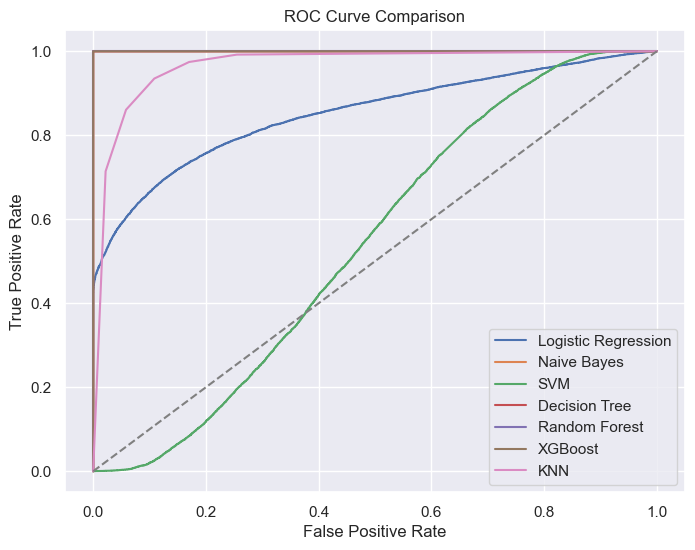

In [2]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(8,6))

for name, model in trained_models.items():
    try:
        y_proba = model.predict_proba(X_test)[:,1]
    except:
        continue

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=name)

plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

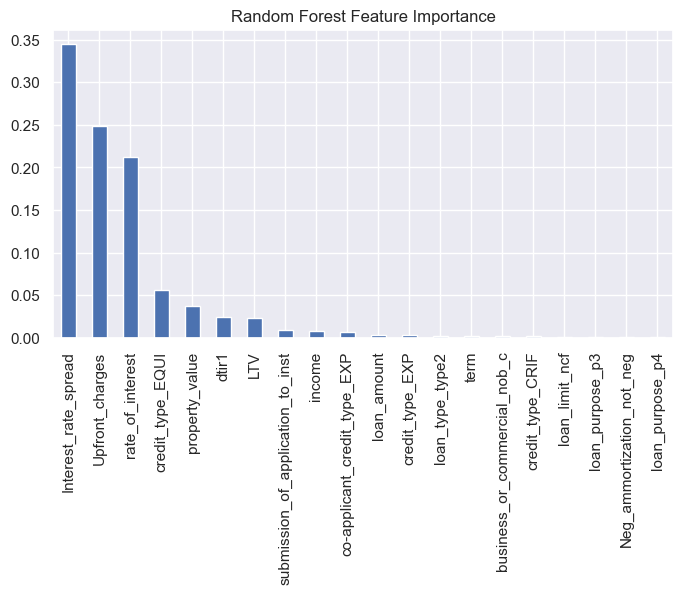

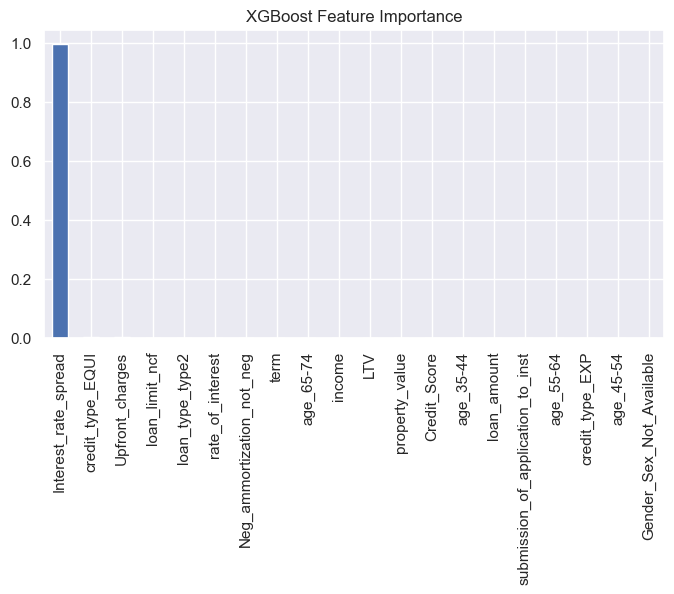

In [3]:
def plot_importances(model, title):
    if hasattr(model, "feature_importances_"):
        imp = pd.Series(model.feature_importances_, index=X.columns)
        imp.sort_values(ascending=False).head(20).plot(kind='bar', figsize=(8,4))
        plt.title(title)
        plt.show()

plot_importances(trained_models["Random Forest"], "Random Forest Feature Importance")
plot_importances(trained_models["XGBoost"], "XGBoost Feature Importance")